<a href="https://colab.research.google.com/github/UCDAyoung/DataAnalysisProgramming/blob/main/hwOfLecture7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin data
In this lab, we would like to explore *Time-Series* data about Bitcoin price.

**[TODO]** Since the data is acquired too frequently, we would like to downsample the data to have a value only once in a week. Please refer the [documents](https://rfriend.tistory.com/494) of `resample().mean()` method.

In [1]:
from dateutil.parser import parse 
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.rcParams.update({'figure.figsize': (10, 7),
                     'figure.dpi': 120})

# Import as Dataframe



df_original = pd.read_csv('https://raw.githubusercontent.com/choi-hyunsoo/DAP/main/coin_Bitcoin.csv',
                 parse_dates=['Date']).set_index('Date')
df = pd.DataFrame(df_original).select_dtypes(include= np.number)
df.head()

,SNo,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,
2013-04-29 23:59:59,1,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
2013-04-30 23:59:59,2,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2013-05-01 23:59:59,3,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
2013-05-02 23:59:59,4,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
2013-05-03 23:59:59,5,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


# Draw Plot

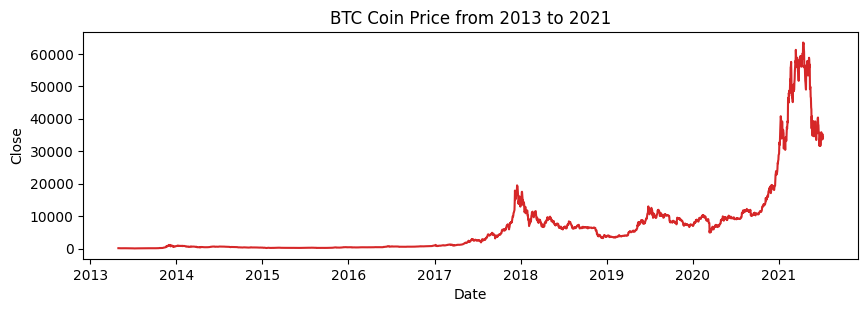

In [2]:
def plot_df(x, y, title="", xlabel='Date', ylabel='Close', dpi=100):
    plt.figure(figsize=(10,3), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(x=df.index, y=df.Close, 
        title='BTC Coin Price from 2013 to 2021')    

**[TODO]** Draw `Year-wise Box Plot` and `Month-wise Box Plot`.

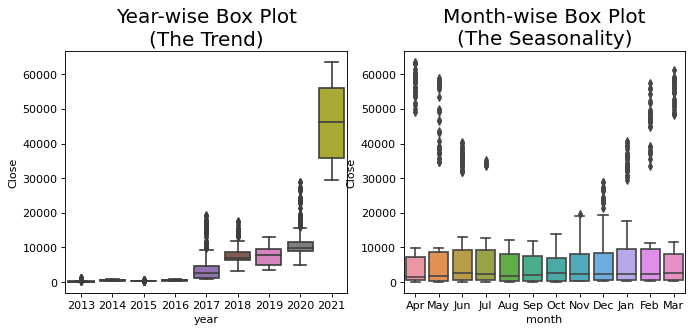

In [3]:
# Prepare data
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(10,4), dpi= 80)
sns.boxplot(x="year",y="Close",data = df,ax=axes[0])
sns.boxplot(x='month',y='Close',data = df,ax=axes[1])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

Decomposite the data into Trend, Seasonal, Residual using `seasonal_decompose`.

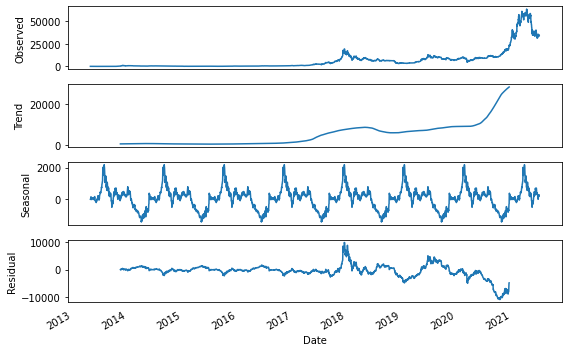

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Decomposition 
decompositionResult = seasonal_decompose(df.Close,freq = 400)


# Plot
plt.rcParams.update({'figure.figsize': (8,5)})
decompositionResult.plot()
plt.show()

# Interpolation
Due to some errors in databes, the data of the first quater is lost. So we would like to guess the value using interpolation.

In [7]:
# Generate the missing data
df_missing = df.copy()
df_missing[(df.index.month <= 3)] = np.nan

**[TODO]** Forward and Backward Fill loss seems to be not proper. Please apply Linear Interpolation.

In [16]:
from scipy.interpolate import interp1d

# Forward Fill
df_ffill = df_missing.ffill()

# Backward Fill
df_bfill = df_missing.bfill()

# Linear Interpolation
# df_lfill = df.copy().interpld()
# df_nona = df.dfopna(sbuset=['value'])
# f = interpld(df_nona['rownum'],df_nona['value'])
# df['linear_fil'] = f(df['rownum'])
#
#
#
# df_lfill.Close = #

AttributeError: ignored

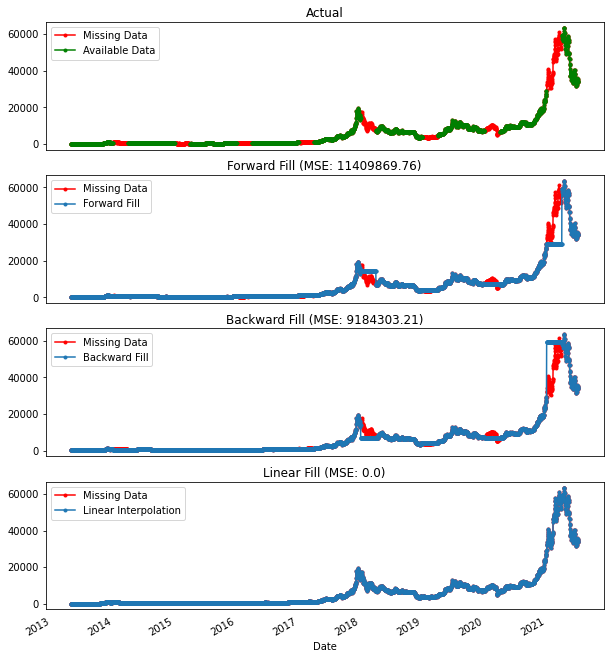

In [14]:
# Calculate Error
from sklearn.metrics import mean_squared_error

error_ffill = np.round(mean_squared_error(df['Close'], df_ffill['Close']), 2)
error_bfill = np.round(mean_squared_error(df['Close'], df_bfill['Close']), 2)
error_lfill = np.round(mean_squared_error(df['Close'], df_lfill['Close']), 2)

# Plotting
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 12))
plt.rcParams.update({'xtick.bottom' : False})

for ax in axes:
  df.Close.plot(title='Actual', ax=ax, label='Actual', color='red', style=".-")

df_missing.Close.plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")
df_ffill.Close.plot(title='Forward Fill (MSE: ' + str(error_ffill) +")", ax=axes[1],
                       label='Forward Fill', style=".-")
df_bfill.Close.plot(title="Backward Fill (MSE: " + str(error_bfill) +")", ax=axes[2],
                       label='Back Fill', style=".-")
df_lfill.Close.plot(title="Linear Fill (MSE: " + str(error_lfill) +")",
                       ax=axes[3], label='Cubic Fill', style=".-")


# Add legend
methods = ['Available Data', 'Forward Fill',
           'Backward Fill', 'Linear Interpolation']
for ax, mt in zip(axes, methods):
  ax.legend(["Missing Data", mt])


# Interpolation References:
# https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html
# https://docs.scipy.org/doc/scipy/reference/interpolate.html

# Smoothing

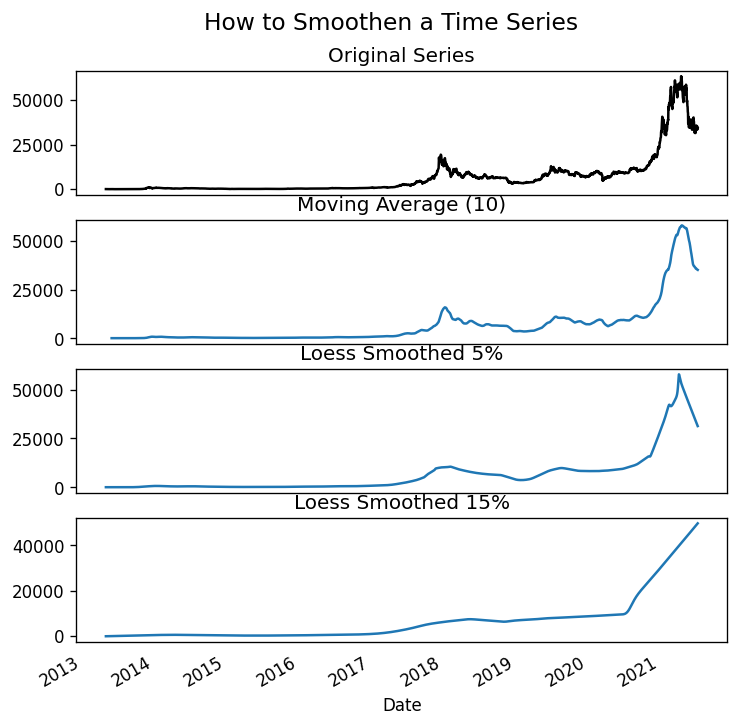

In [13]:
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# 1. Moving Average
df_ma = df.Close.rolling(30).mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(
    lowess(df.Close, np.arange(len(df.Close)), frac=0.05)[:, 1],
    index=df.index, columns=['Close'])

df_loess_15 = pd.DataFrame(
    lowess(df.Close, np.arange(len(df.Close)), frac=0.15)[:, 1],
    index=df.index, columns=['Close'])

# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)

df['Close'].plot(ax=axes[0], color='k', title='Original Series')
df_ma.plot(ax=axes[1], title='Moving Average (10)')
df_loess_5['Close'].plot(ax=axes[2], title='Loess Smoothed 5%')
df_loess_15['Close'].plot(ax=axes[3], title='Loess Smoothed 15%')

fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()